## IMPORTS

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pymongo
import dotenv
import os
import datetime

## MONGODB CONNECTION SETUP

In [2]:
dotenv.load_dotenv()

db_host = os.getenv("MONGODB_HOST")
db_port = int(os.getenv("MONGODB_PORT"))
db_name = os.getenv("MONGODB_DBNAME")
db_username = os.getenv("MONGODB_USERNAME")
db_password = os.getenv("MONGODB_PASSWORD")

client = pymongo.MongoClient(f"mongodb://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}?authSource=admin")

db = client['itb_db']

ypricedatas = db['ypricedatas']
stocks = db['stocks']

## UTILS

In [38]:
# arr: list<x> = list to be filtered
# pr: lambda<x, boolean> = filter condition
def filter_array (arr, pr) :
  result = []
  for a in arr :
    if pr(a) :
      result.append(a)
  return result

# arr: list<x> = list to be mapped
# fn: lambda<x, any> = callback that tells what to map each entry
# pr: lambda<x, boolean> = condition to filter mapping entries [default: a lambda that always returns true]
def map_array (arr, fn, pr=lambda x : True) :
  result = []
  for a in arr :
    if pr(a) :
      result.append(fn(a))
  return result

  ## WHERE THE MAGIC HAPPENS

In [79]:


# stock: string
# start_timestamp: datetime
# end_timestamp: datetime
def plot_stock(stock, start_timestamp, end_timestamp) :
  start_timestamp_unix = int(start_timestamp.timestamp())
  end_timestamp_unix = int(end_timestamp.timestamp())

  ypricedatas_documents = ypricedatas.find({'id': stock, 'time': {'$gte': start_timestamp_unix*1000, "$lte": end_timestamp_unix*1000}, 'price': {'$gt': 0}}).sort('time')
  stocks_documents = stocks.find({'stockName': stock})

  prices = [doc['price'] for doc in ypricedatas_documents]
  timestamps = [datetime.datetime.fromtimestamp(doc['time']/1000) for doc in ypricedatas_documents.rewind()]

  stocks_ops = []

  for doc in stocks_documents :
    stocks_ops.extend(map_array(doc['buysAndSells'], lambda bs : bs))

  stocks_ops.sort(key=lambda s : s['timeStamp'])

  print(stocks_ops.__len__())

  op_prices = []
  op_timestamps = []

  if stocks_ops.__len__() > 0 :
    print(f"begin: {start_timestamp_unix}")
    print(f"bd:    {int(stocks_ops[0]['timeStamp'].timestamp())}")
    print(f"end:   {end_timestamp_unix}")

    op_prices = map_array(
      filter_array(
        stocks_ops, 
        lambda bs : start_timestamp_unix <= int(bs['timeStamp'].timestamp()/1000) < end_timestamp_unix
      ), 
      lambda bs : bs['currPrice']
    )

    op_timestamps.extend(map_array(stocks_ops, lambda bs : bs['timeStamp']))
    
    op_timestamps = filter_array(
      op_timestamps, 
      lambda ts : start_timestamp_unix <= int(ts.timestamp()) < end_timestamp_unix
    )

  # Plot the data
  fig, ax = plt.subplots()
  ax.plot(timestamps, prices)

  fig.set_figwidth(20)
  fig.set_figheight(2.7)
  fig.set_constrained_layout(True)

  ax.scatter(op_timestamps, op_prices, facecolor='#FF0000')
  ax.set_xlabel('Time')
  ax.set_ylabel('Price')
  ax.set_title(f"{stock} Fluctuation {start_timestamp.year}/{start_timestamp.month}/{start_timestamp.day} {start_timestamp.hour}:{start_timestamp.minute} - {end_timestamp.year}/{end_timestamp.month}/{end_timestamp.day} {end_timestamp.hour}:{end_timestamp.minute}")

42159
begin: 1676402400
bd:    1676414005
end:   1676403000


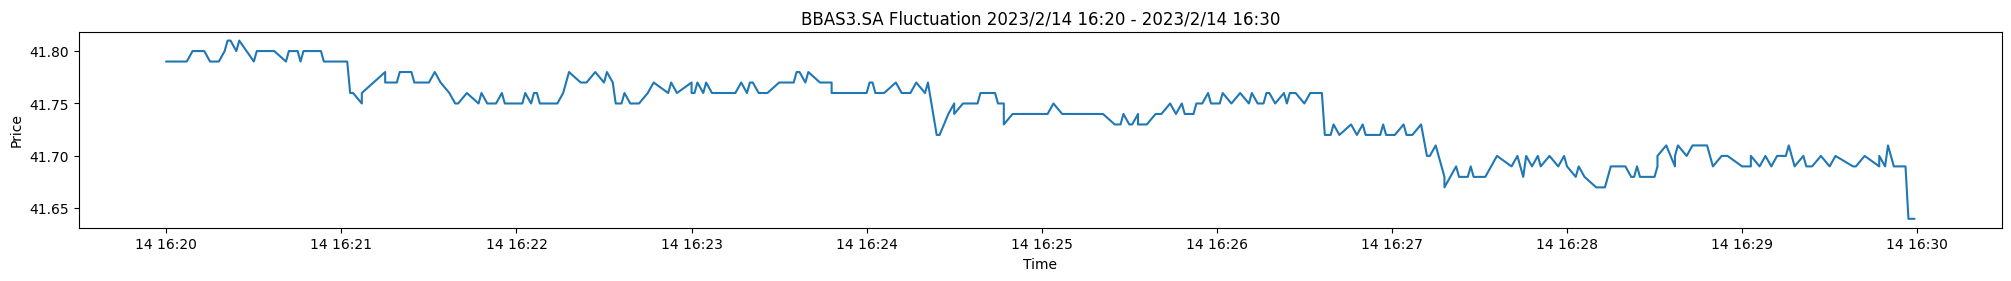

In [80]:
plot_stock('BBAS3.SA', datetime.datetime(2023, 2, 14, 16, 20, 0), datetime.datetime(2023, 2, 14, 16, 30, 0))

0


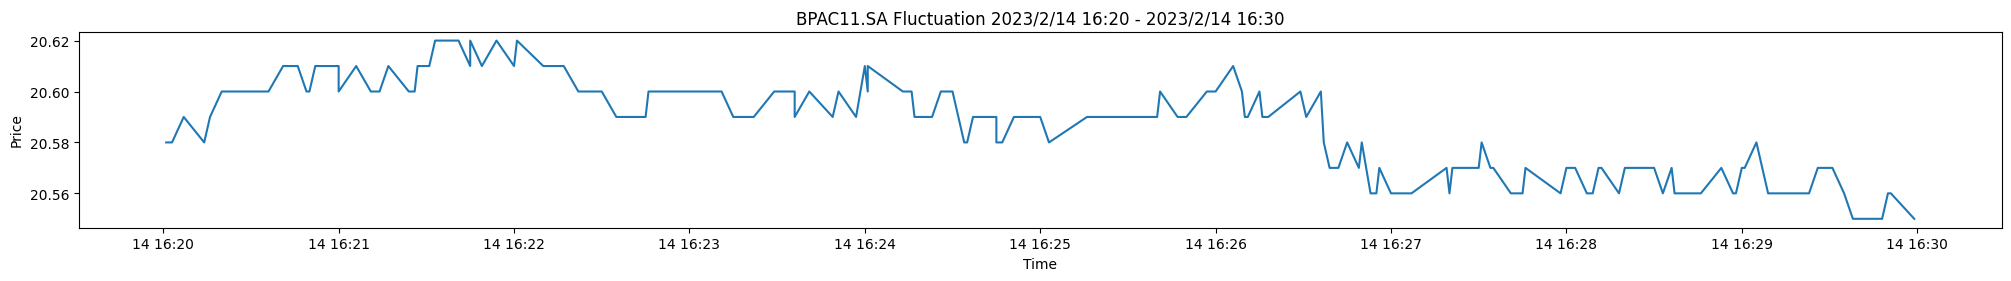

In [81]:
plot_stock('BPAC11.SA', datetime.datetime(2023, 2, 14, 16, 20, 0), datetime.datetime(2023, 2, 14, 16, 30, 0))

13915
begin: 1676402400
bd:    1676414063
end:   1676403000


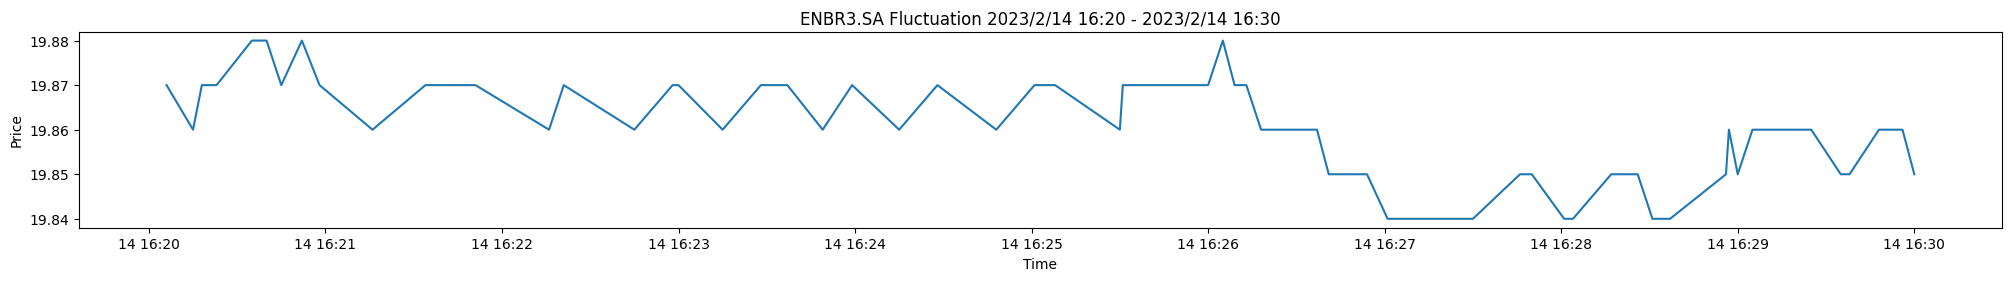

In [82]:
plot_stock('ENBR3.SA', datetime.datetime(2023, 2, 14, 16, 20, 0), datetime.datetime(2023, 2, 14, 16, 30, 0))